In [1]:
import pandas as pd
import numpy as np
from pyproj import Proj
from scipy.spatial import cKDTree
from netCDF4 import Dataset
from datetime import datetime, timedelta

class RealWind:
    def __init__(self, start_date="2019-10-01", num_days=9):
        self.proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
        self.wind_by_time = {}
        self.kdtrees = {}

        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        layer_range = (56, 68)
        bounding_box = (140.5, -39, 150, -34)

        for day_offset in range(num_days):
            current_date = start_date + timedelta(days=day_offset)
            date_str = current_date.strftime('%Y%m%d')
            file_path = rf"C:\\Users\\Nur Izfarwiza\\Documents\\Dissertation\\Wind\\MERRA2_400.tavg3_3d_asm_Nv.{date_str}.nc4"

            try:
                dataset = Dataset(file_path, 'r')
                lats = dataset.variables['lat'][:]
                lons = dataset.variables['lon'][:]

                lat_indices = np.where((lats >= bounding_box[1]) & (lats <= bounding_box[3]))[0]
                lon_indices = np.where((lons >= bounding_box[0]) & (lons <= bounding_box[2]))[0]

                lats = lats[lat_indices]
                lons = lons[lon_indices]

                eastward_wind = dataset.variables['U'][:, :, lat_indices, :][:, :, :, lon_indices]
                northward_wind = dataset.variables['V'][:, :, lat_indices, :][:, :, :, lon_indices]

                layer_range_slice = slice(layer_range[0], layer_range[1])
                eastward_wind_avg = np.mean(eastward_wind[:, layer_range_slice, :, :], axis=1)
                northward_wind_avg = np.mean(northward_wind[:, layer_range_slice, :, :], axis=1)

                time_var = np.array(dataset.variables['time'][:], dtype=np.float64)

                for t_idx, t_val in enumerate(time_var):
                    if not np.isfinite(t_val):
                        continue
                    timestamp = int((t_val * 60) // 10800 * 10800)  # Round to nearest 3-hour (in seconds)

                    lon_grid, lat_grid = np.meshgrid(lons, lats)
                    easting, northing = self.proj(lon_grid, lat_grid)

                    easting = easting.flatten()
                    northing = northing.flatten()
                    u_wind = eastward_wind_avg[t_idx].flatten()
                    v_wind = northward_wind_avg[t_idx].flatten()

                    valid_mask = np.isfinite(easting) & np.isfinite(northing) & np.isfinite(u_wind) & np.isfinite(v_wind)
                    data = np.stack([easting[valid_mask], northing[valid_mask], u_wind[valid_mask], v_wind[valid_mask]], axis=1)

                    if timestamp not in self.wind_by_time:
                        self.wind_by_time[timestamp] = data
                    else:
                        self.wind_by_time[timestamp] = np.vstack([self.wind_by_time[timestamp], data])

                dataset.close()

            except Exception as e:
                print(f"Error loading {date_str}: {e}")

        for ts_key, data in self.wind_by_time.items():
            self.kdtrees[ts_key] = cKDTree(data[:, :2])

        print(f"Loaded wind data for {len(self.wind_by_time)} timestamps.")

    def getwind(self, coords):
        num_particles, num_observations, _ = coords.shape
        wind_data = np.full((num_particles, num_observations, 2), np.nan)

        flat_coords = coords.reshape(-1, 3)
        timestamps = (flat_coords[:, 0] // 10800 * 10800).astype(int)
        unique_ts = np.unique(timestamps)

        for ts in unique_ts:
            if ts not in self.kdtrees:
                continue

            mask = timestamps == ts
            coords_subset = flat_coords[mask]
            spatial_coords = coords_subset[:, 1:3]

            tree = self.kdtrees[ts]
            data = self.wind_by_time[ts]

            _, idx = tree.query(spatial_coords)
            wind_vals = data[idx, 2:]

            wind_data.reshape(-1, 2)[mask] = wind_vals

        return wind_data


Loaded wind data for 8 timestamps.
Initialising particles...
Diffusing particles...


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_6480\4035870531.py:41: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_6480\4035870531.py:41: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)


Computing SS...
Inverting SS...
Computing meanZ
Done
Initialising particles...
Particle shape:
(5, 12000, 3)
Diffusing particles...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 10, 10)
Computing Source from Phi...


c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\models\mesh_model.py:79: RuntimeWarning: invalid value encountered in cast
  return np.floor(self.resolution*(realPos - self.boundary[0])/(self.boundary[1]-self.boundary[0])).astype(int)


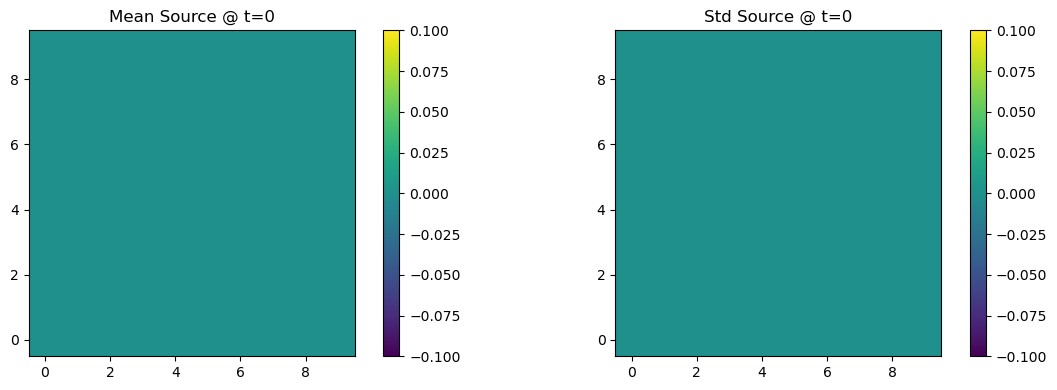

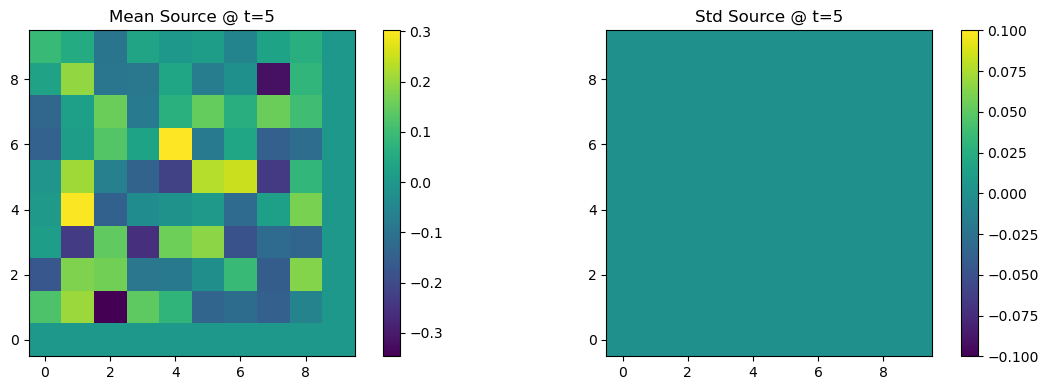

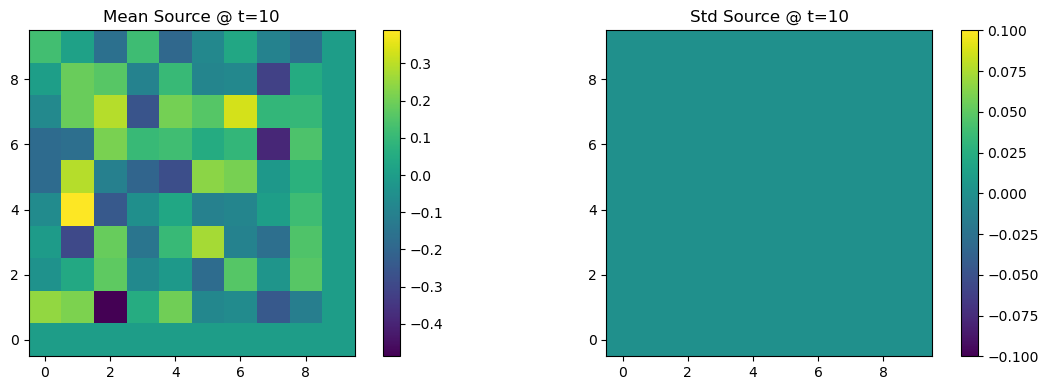

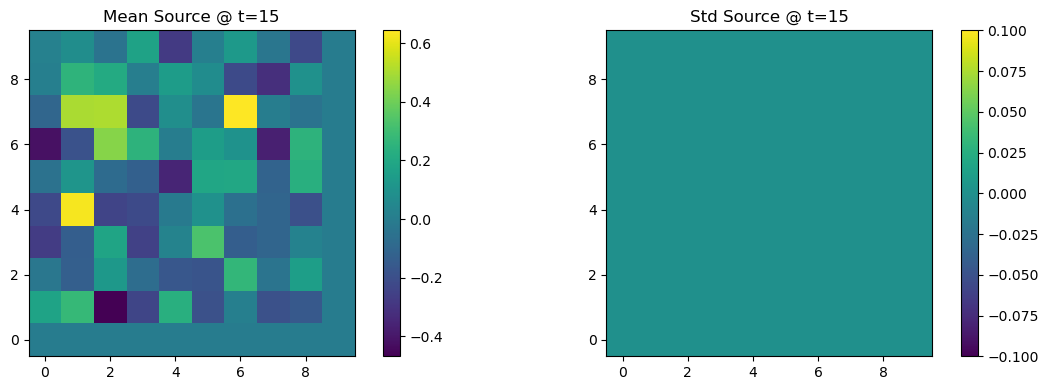

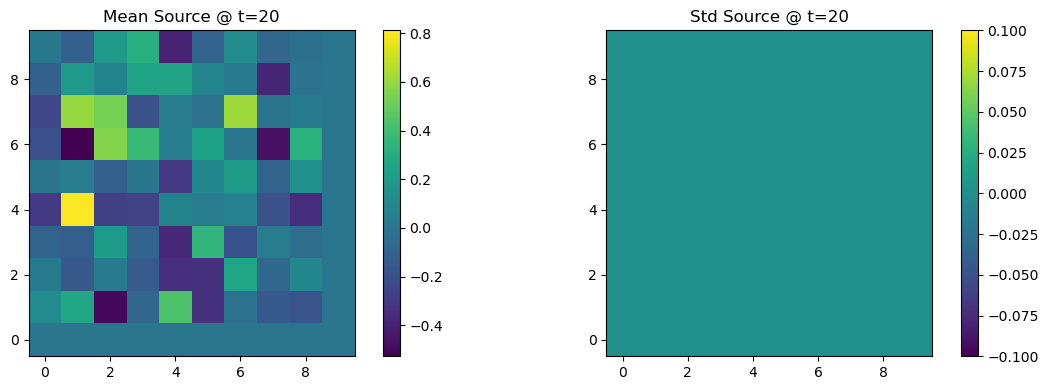

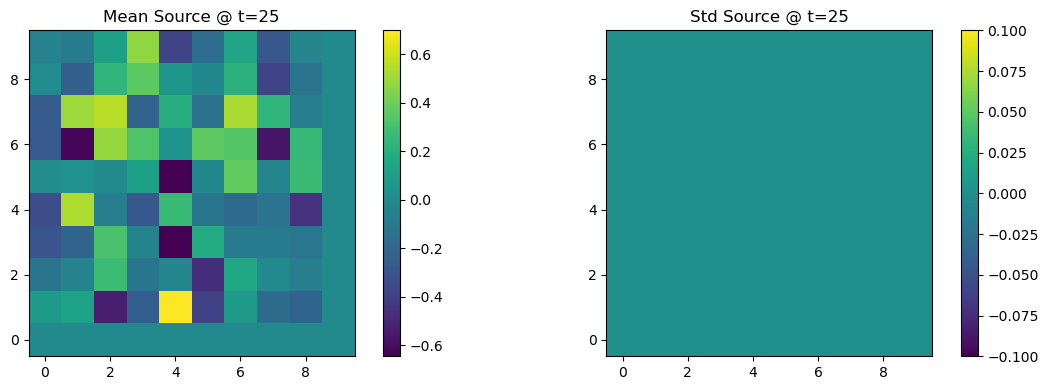

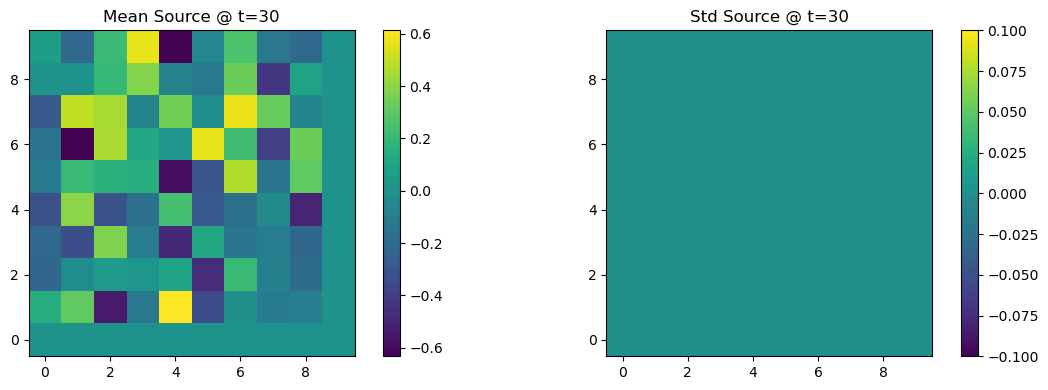

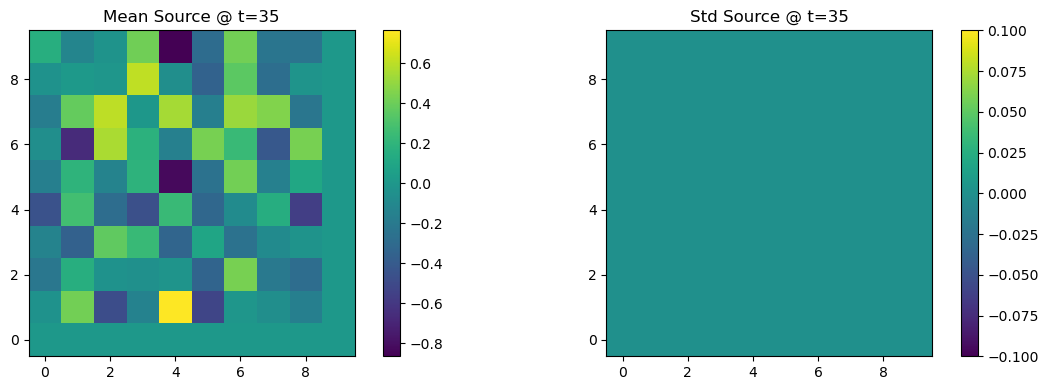

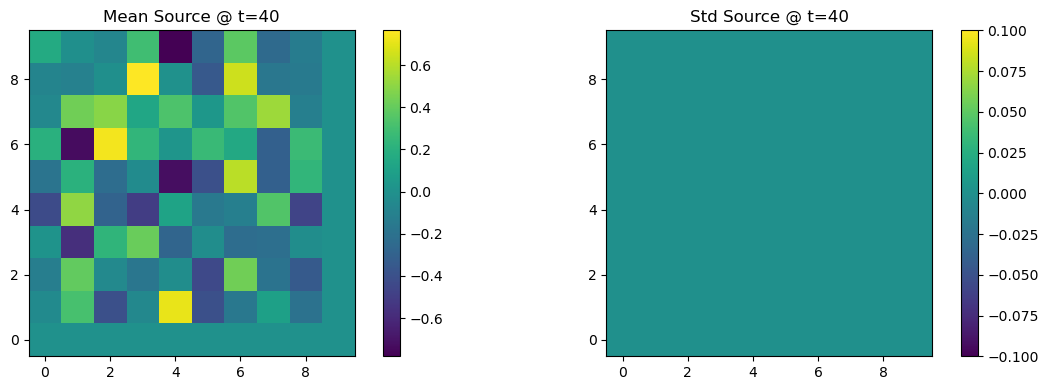

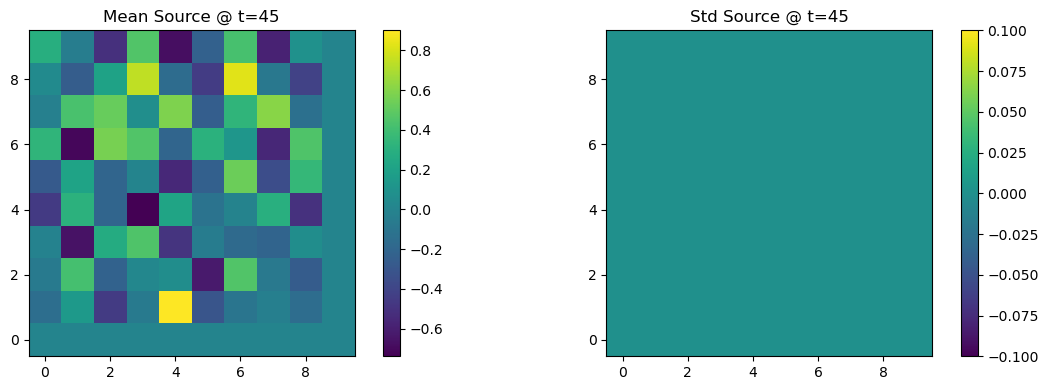

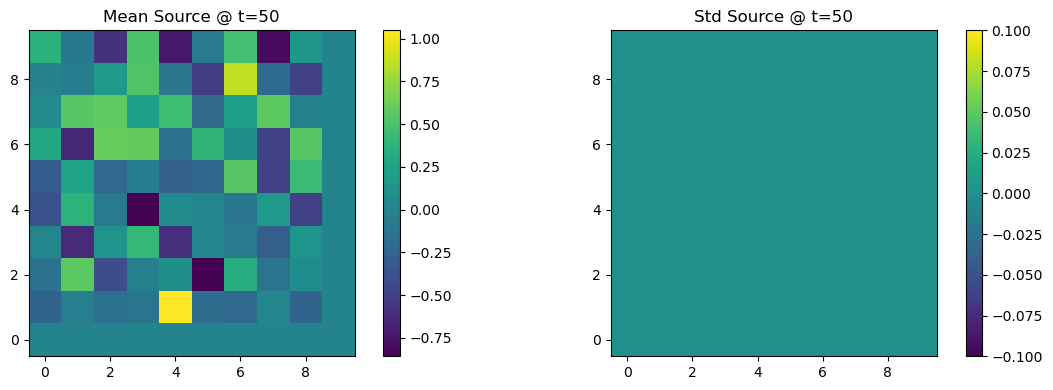

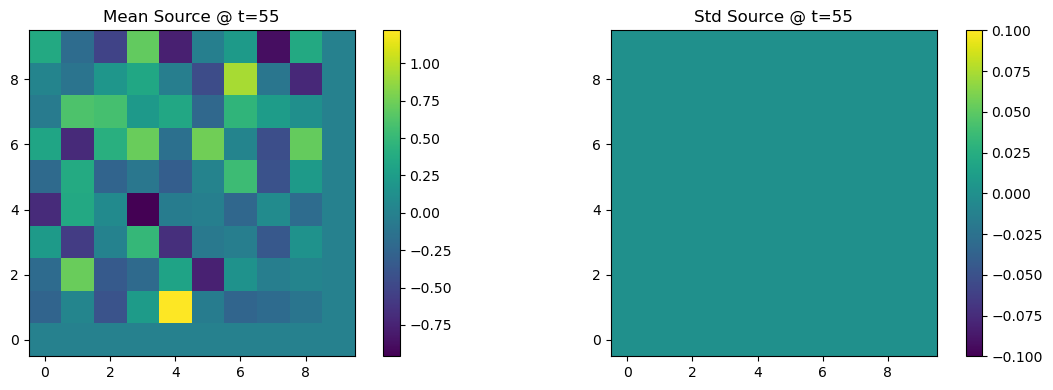

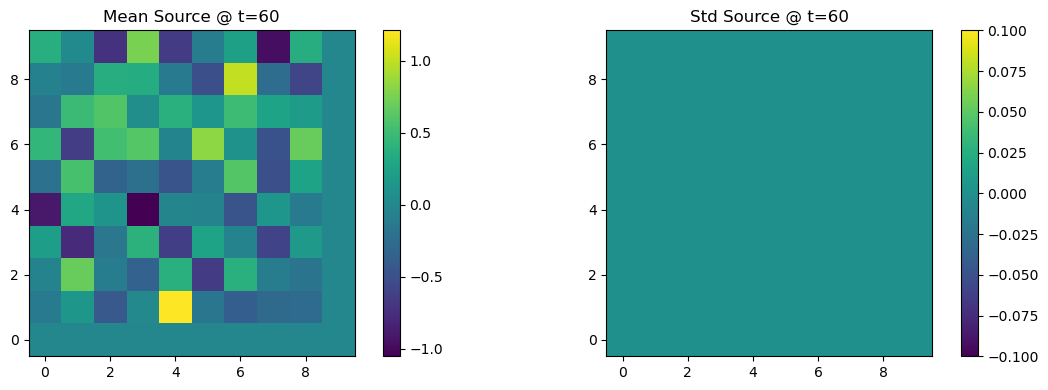

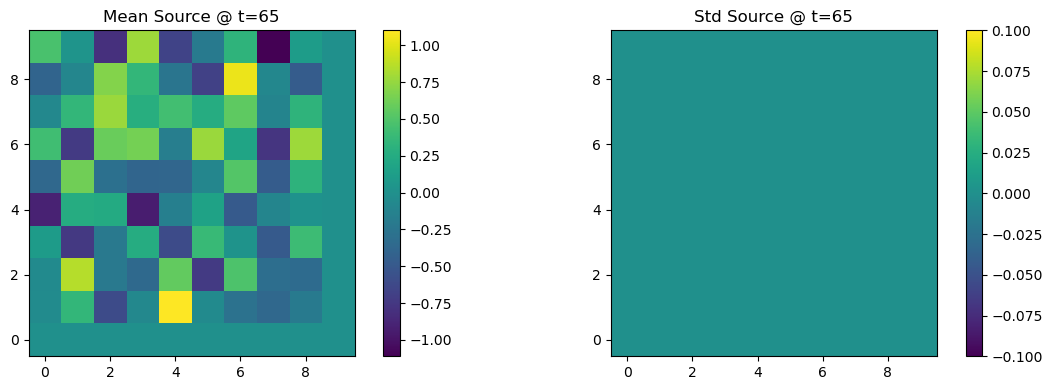

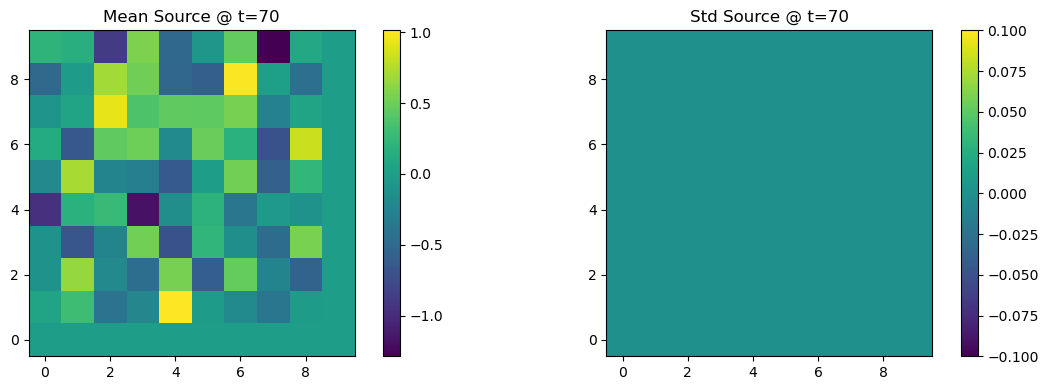

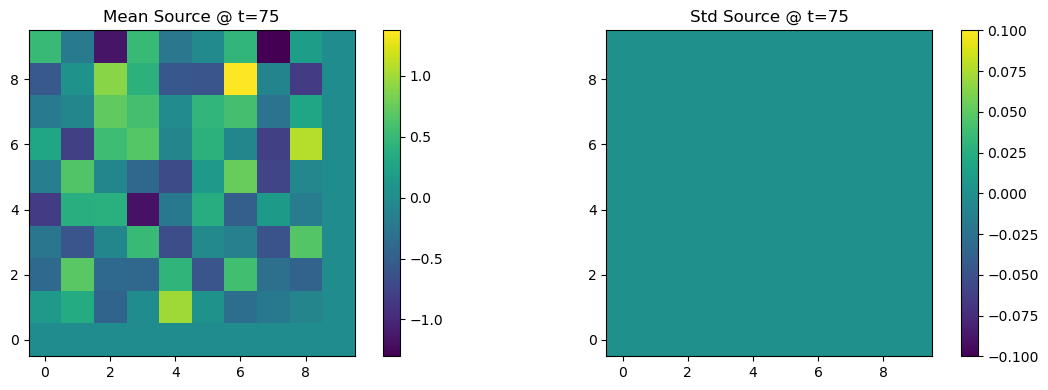

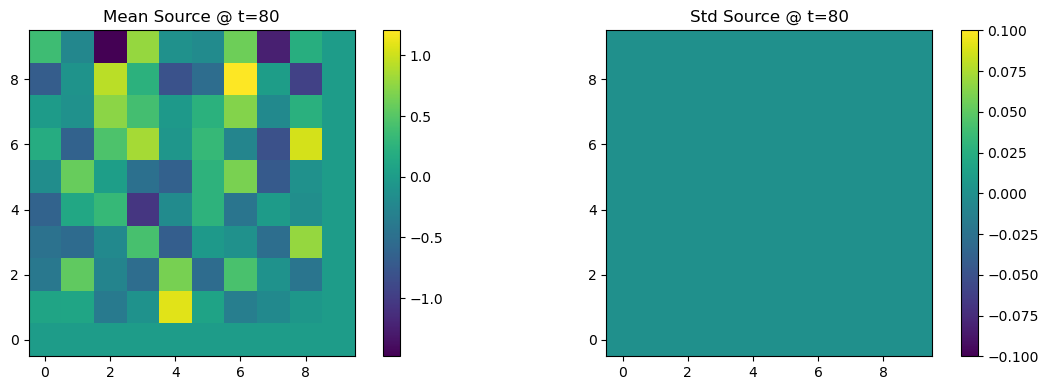

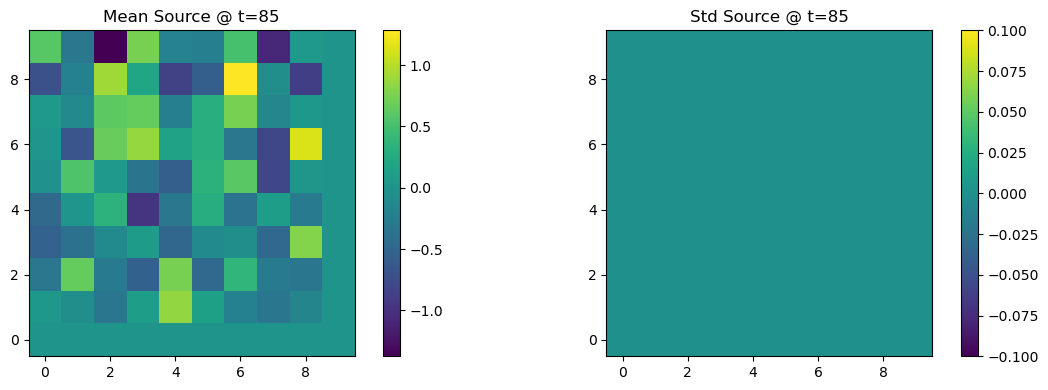

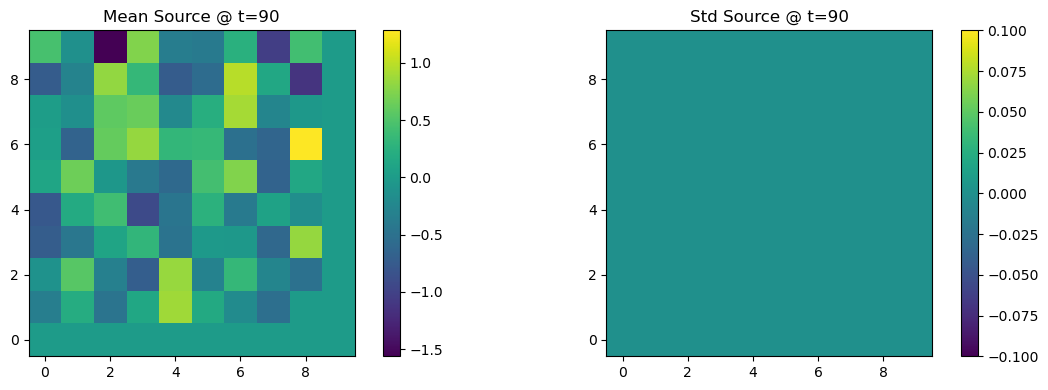

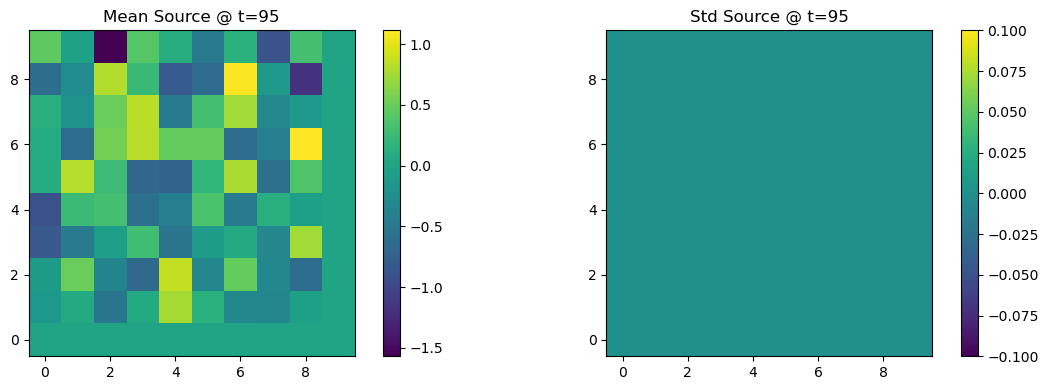

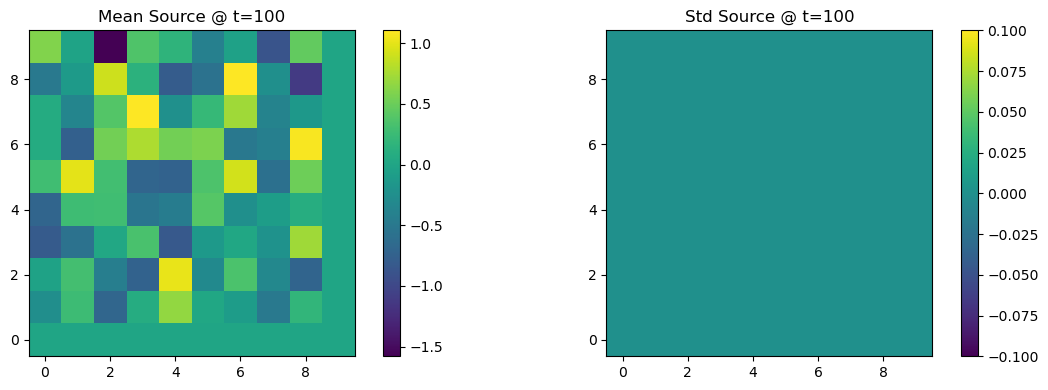

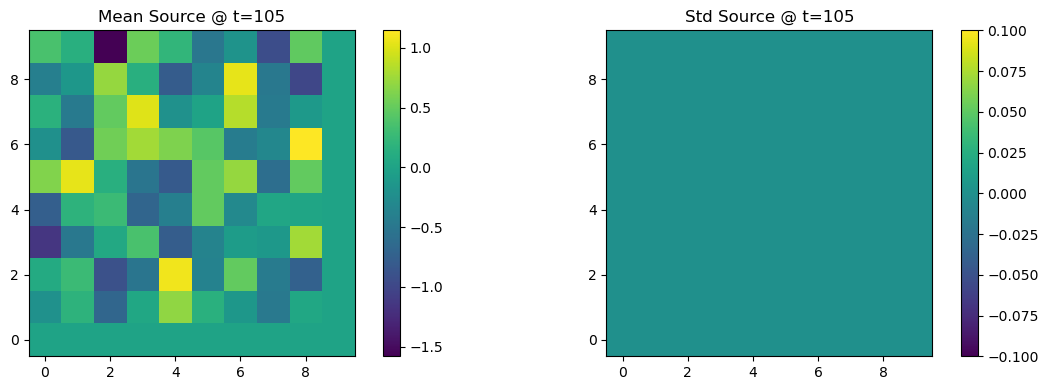

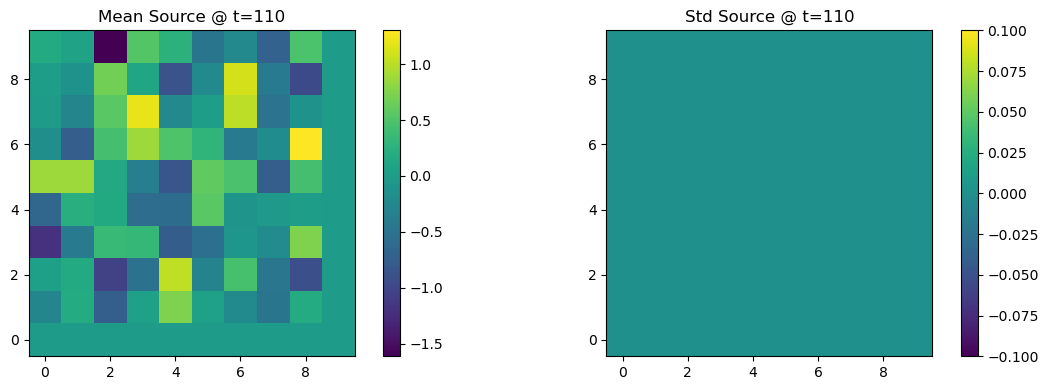

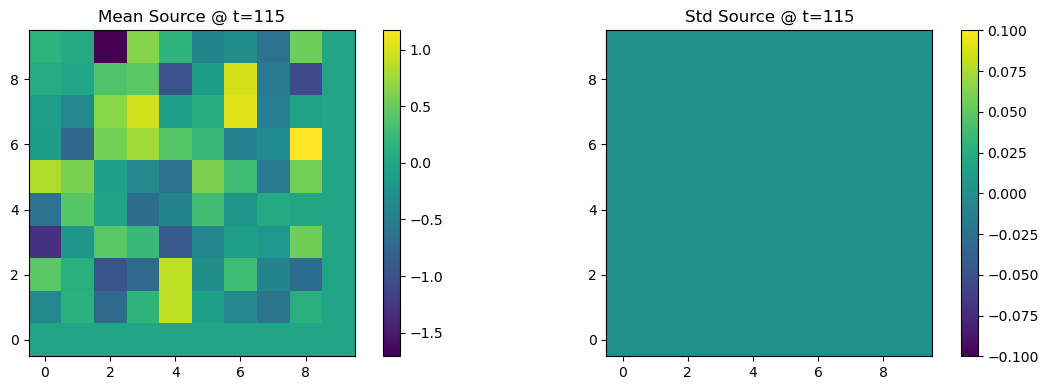

In [2]:
from pyproj import Proj
import numpy as np
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Define Observation-Like Bounding Box ===
# # Use fake obsLocs just for proposeboundary
# dummy_obsLocs = np.array([[0, 1440, x, y] for x in np.linspace(xmin, xmax, 5) for y in np.linspace(ymin, ymax, 10)])
# boundary = proposeboundary(dummy_obsLocs)
# padding = 50_000
# boundary = (
#     np.array(boundary[0]),
#     np.array(boundary[1])
# )
# boundary[0][1:] -= padding
# boundary[1][1:] += padding

# === Step 1: Setup UTM Projection ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
# Convert lat/lon bounding box of Victoria to UTM
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 600, 1440
sensors = RemoteSensingModel(num_particles=3)
# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start, t_end, x, y])

obsLocs = np.array(obsLocs)

boundary = proposeboundary(obsLocs)
padding = 50000
boundary = (np.array(boundary[0]), np.array(boundary[1]))
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 3: Sensor Model (no longer needs getHs) ===
# sensors = RemoteSensingModel(num_particles=10)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1000
k = EQ(10, 1)
res = [120, 10, 10]
noiseSD = 0.001
k_0 = 0.01
windmodel = RealWind(start_date="2019-10-01", num_days=1)
# windmodel = WindSimple(1, 1)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]

# === Step 7: Generate Synthetic Observations ===
def generate_Y_from_obsLocs(obsLocs, centre_x, centre_y, D=2e7):
    Y = []
    for t_start, t_end, x, y in obsLocs:
        t = (t_start + t_end) / 2.0
        d = np.linalg.norm([x - centre_x, y - centre_y])
        
        # Clip blobsize to avoid extreme values
        blobsize = np.sqrt(2 * 2 * D * (t + 4))
        blobsize = np.clip(blobsize, 1, 1e6)
        
        try:
            spatial = norm(0, blobsize).pdf(d)
            temporal = norm(600, 300).cdf(t)  # Change from norm(10,1) to something meaningful
            v = 1000 * spatial * temporal / blobsize
        except:
            v = 0.0  # fallback if anything breaks
        
        if not np.isfinite(v):  # guard against nan/inf
            v = 0.0
        Y.append(v)
    
    return np.array(Y)


centre_x = (xmin + xmax) / 2
centre_y = (ymin + ymax) / 2
Y = generate_Y_from_obsLocs(obsLocs[:num_obs], centre_x, centre_y, D=2e7)
Y = Y.reshape(-1)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=1,
    Nparticles=5,
    coords=coords,
    interpolateSource=True
)

# === Step 11: Plotting ===
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
step_interval = int(10800 / dt_seconds)

for t_index in range(0, res[0], 5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Mean Source @ t={t_index}")
    plt.imshow(sourcemean[t_index], origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Std Source @ t={t_index}")
    plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
    plt.colorbar()
    plt.tight_layout()
    plt.show()



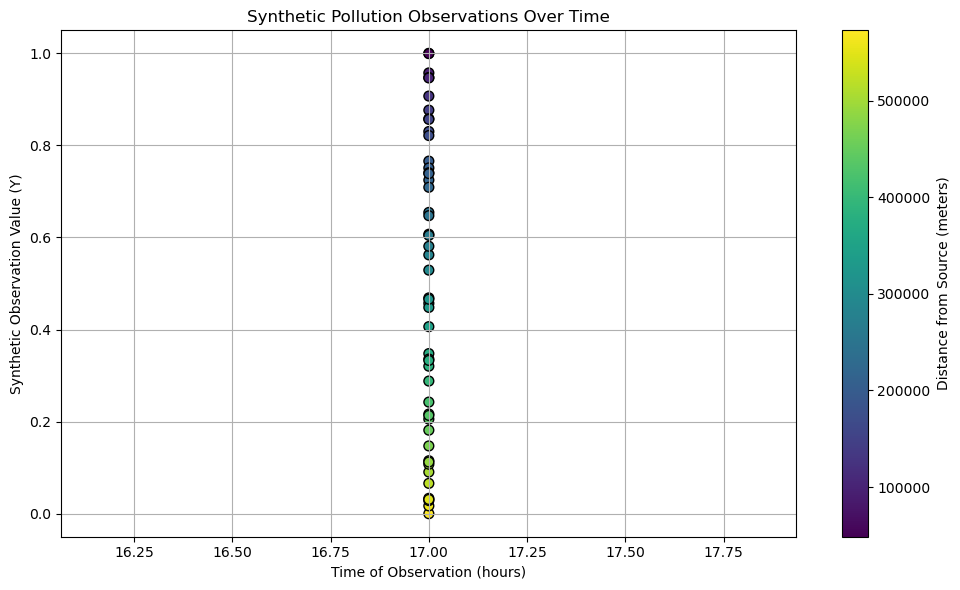

In [3]:
import matplotlib.pyplot as plt

# First, unpack the times and distances for analysis
sensor_times = [(t_start + t_end) / 2.0 for t_start, t_end, x, y in obsLocs]
sensor_distances = [np.linalg.norm([x - centre_x, y - centre_y]) for t_start, t_end, x, y in obsLocs]

# Convert times to hours for readability
sensor_times = np.array(sensor_times) / 60  # minutes → hours
Y_values = Y

# --- Option 1: Plot all sensor values over time (scatter or line) ---
plt.figure(figsize=(10, 6))
plt.scatter(sensor_times, Y_values, c=sensor_distances, cmap='viridis', s=50, edgecolor='k')
plt.colorbar(label='Distance from Source (meters)')
plt.xlabel("Time of Observation (hours)")
plt.ylabel("Synthetic Observation Value (Y)")
plt.title("Synthetic Pollution Observations Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


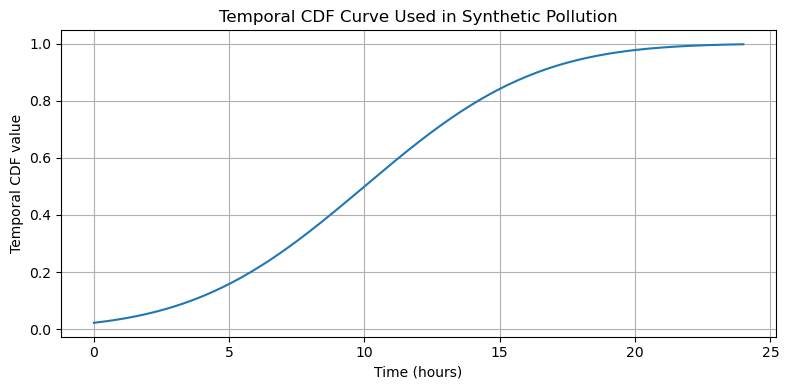

In [4]:
from scipy.stats import norm

times = np.linspace(0, 1440, 200)  # minutes
cdf = norm(600, 300).cdf(times)

plt.figure(figsize=(8, 4))
plt.plot(times / 60, cdf)
plt.xlabel("Time (hours)")
plt.ylabel("Temporal CDF value")
plt.title("Temporal CDF Curve Used in Synthetic Pollution")
plt.grid(True)
plt.tight_layout()
plt.show()


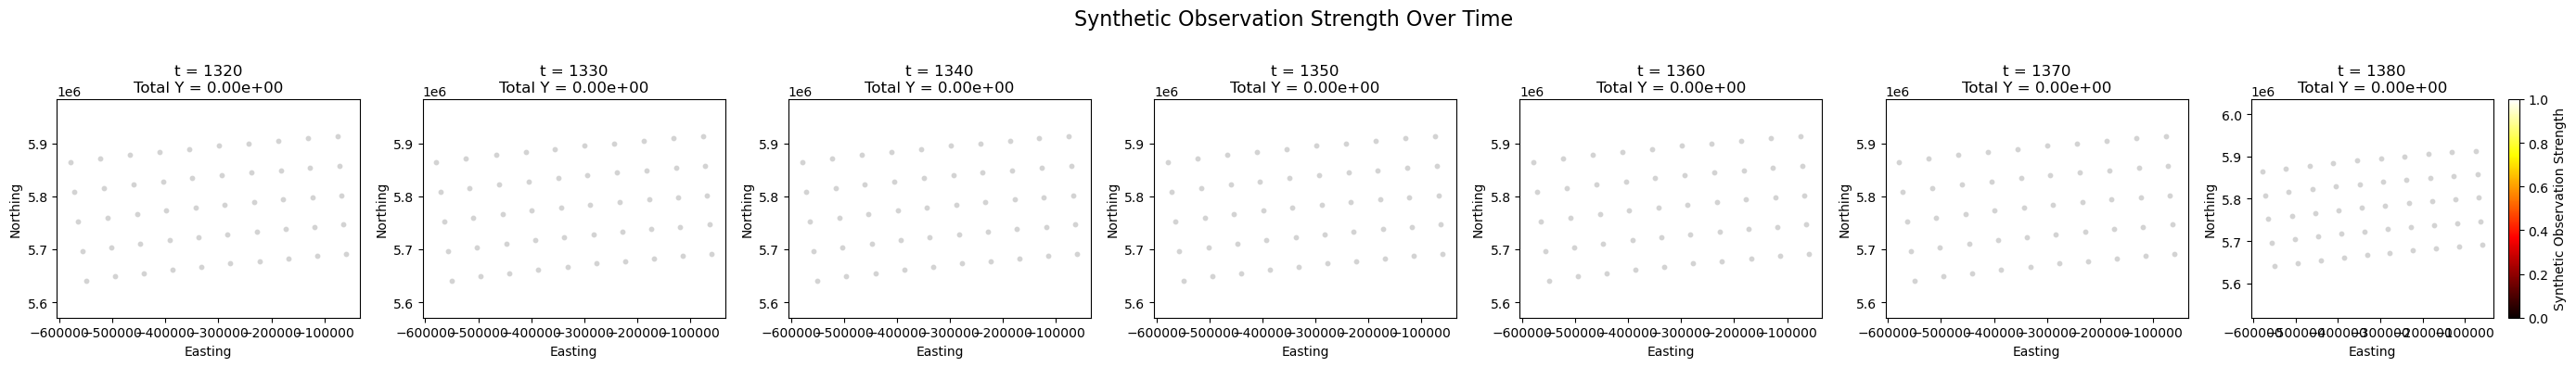

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Use midpoint time for each observation
obsTimes = (obsLocs[:num_obs, 0] + obsLocs[:num_obs, 1]) / 2
xs = obsLocs[:num_obs, 2]
ys = obsLocs[:num_obs, 3]

# Define time bins to visualize
time_bins = np.arange(1320, 1381, 10)# every 30 minutes
n_plots = len(time_bins)

plt.figure(figsize=(4 * n_plots, 4))
for i, t in enumerate(time_bins):
    plt.subplot(1, n_plots, i + 1)
    
    # Filter observations near this time
    keep = np.abs(obsTimes - t) < 15  # ±15 minutes window
    
    plt.scatter(xs, ys, color='lightgrey', s=10, label='All Sensors')
    sc = plt.scatter(xs[keep], ys[keep], c=Y[keep], cmap='hot', s=100)
    
    plt.title(f"t = {t:.0f}\nTotal Y = {np.sum(Y[keep]):.2e}")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.axis('equal')

plt.colorbar(sc, label='Synthetic Observation Strength')
plt.suptitle("Synthetic Observation Strength Over Time", fontsize=16)
plt.tight_layout()
plt.show()


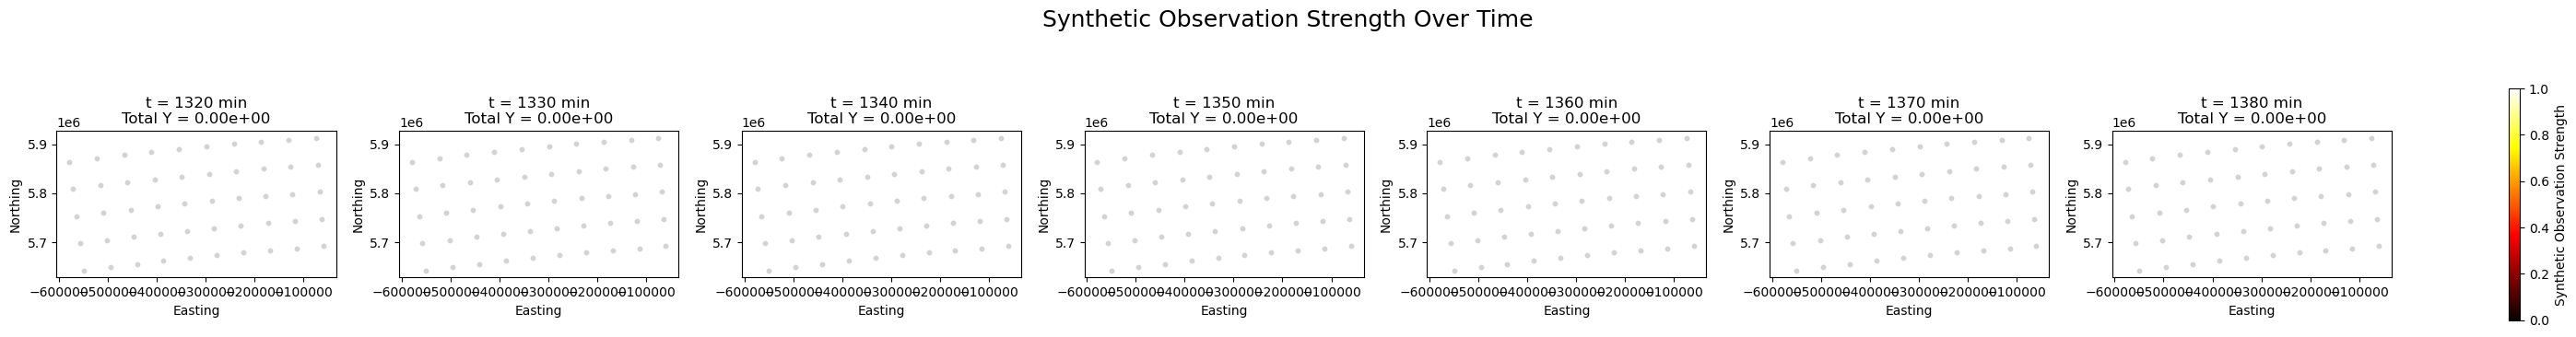

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Use midpoint time for each observation
obsTimes = (obsLocs[:num_obs, 0] + obsLocs[:num_obs, 1]) / 2
xs = obsLocs[:num_obs, 2]
ys = obsLocs[:num_obs, 3]

# Define time bins: every 10 minutes from 1320 to 1380
time_bins = np.arange(1320, 1381, 10)
n_plots = len(time_bins)

# Create subplots
fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4), constrained_layout=True)

# Loop over each time slice
for i, t in enumerate(time_bins):
    ax = axes[i]
    
    # Sensors close to current time (±15 min)
    keep = np.abs(obsTimes - t) < 15
    
    ax.scatter(xs, ys, color='lightgrey', s=10, label='All Sensors')
    sc = ax.scatter(xs[keep], ys[keep], c=Y[keep], cmap='hot', s=100)
    
    ax.set_title(f"t = {t:.0f} min\nTotal Y = {np.sum(Y[keep]):.2e}")
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_aspect('equal')

# Add one colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.7, label="Synthetic Observation Strength")
fig.suptitle("Synthetic Observation Strength Over Time", fontsize=18)
plt.show()


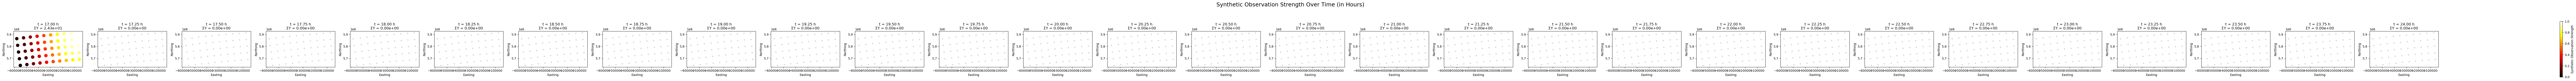

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Convert observation time to hours
obsTimes = (obsLocs[:num_obs, 0] + obsLocs[:num_obs, 1]) / 2 / 60
xs = obsLocs[:num_obs, 2]
ys = obsLocs[:num_obs, 3]

# Define time bins in hours (e.g. from 22.0h to 23.0h in 0.25h steps = 15min)
time_bins = np.arange(17.0, 24.01, 0.25)  # Every 15 minutes
n_plots = len(time_bins)

# Create subplots
fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4), constrained_layout=True)

# Plot each time bin
for i, t in enumerate(time_bins):
    ax = axes[i]
    
    keep = np.abs(obsTimes - t) < 0.125  # ±7.5 minutes (0.125h)

    ax.scatter(xs, ys, color='lightgrey', s=10, label='All Sensors')
    sc = ax.scatter(xs[keep], ys[keep], c=Y[keep], cmap='hot', s=100)
    
    ax.set_title(f"t = {t:.2f} h\nΣY = {np.sum(Y[keep]):.2e}")
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_aspect('equal')

# Shared colorbar
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.7, label="Synthetic Observation Strength")
fig.suptitle("Synthetic Observation Strength Over Time (in Hours)", fontsize=18)
plt.show()


In [8]:
print(f"Observation times range from {obsTimes.min():.2f}h to {obsTimes.max():.2f}h")


Observation times range from 17.00h to 17.00h
